<a href="https://colab.research.google.com/github/ccrespobarreda-ctrl/TFM/blob/main/TFM%20Cris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Entorno configurado correctamente.

Mounted at /content/drive
🚀 Cargando dataset con optimización de memoria...
✅ Dataset cargado: 441,456 filas × 330 columnas
💾 Memoria utilizada: 551.01 MB

🔍 INICIANDO ANÁLISIS EXPLORATORIO AVANZADO

[1] 📐 ESTRUCTURA DEL DATASET
Filas: 441,456 | Columnas: 330

Tipos de datos:
 float32     324
uint16        2
uint8         2
category      1
category      1
Name: count, dtype: int64 

[2] 🔍 ANÁLISIS DE VALORES NULOS
           Nulos           %
QLHLTH2   441456  100.000000
PAINACT2  441456  100.000000
QLMENTL2  441456  100.000000
QLSTRES2  441456  100.000000
COLGHOUS  441411   99.989806
LADULT    441411   99.989806
PCDMDECN  441201   99.942237
ASDRVIST  441144   99.929325
ASERVIST  441143   99.929098
ASNOSLEP  440999   99.896479 



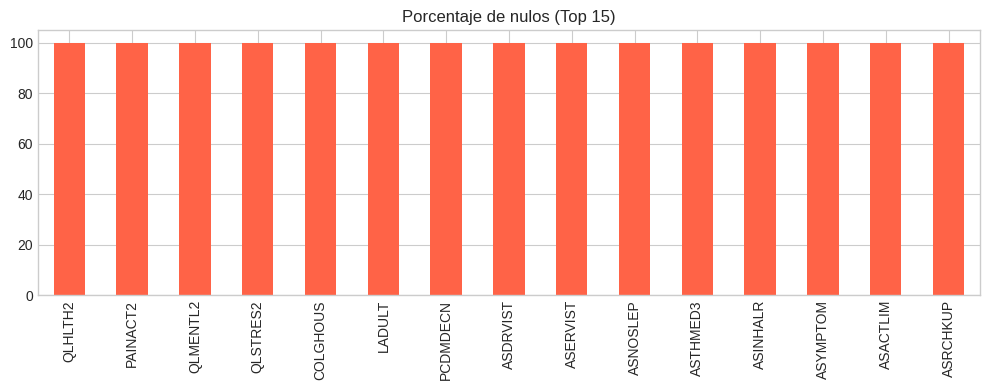

[3] 🎯 DISTRIBUCIÓN DE LA VARIABLE TARGET (DIABETE3)
DIABETE3
1.0     57256
2.0      3608
3.0    372104
4.0      7690
7.0       598
9.0       193
Name: count, dtype: int64 



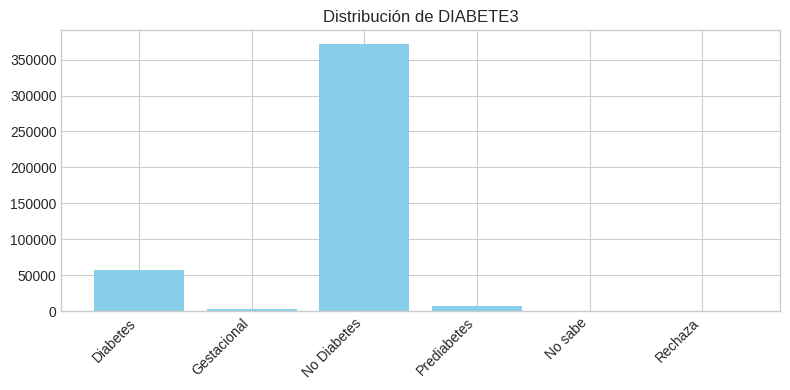

[4] 📊 ANÁLISIS DE CARDINALIDAD
Variables constantes: 5 | Alta cardinalidad: 0

[5] 🔗 CORRELACIONES ENTRE VARIABLES NUMÉRICAS


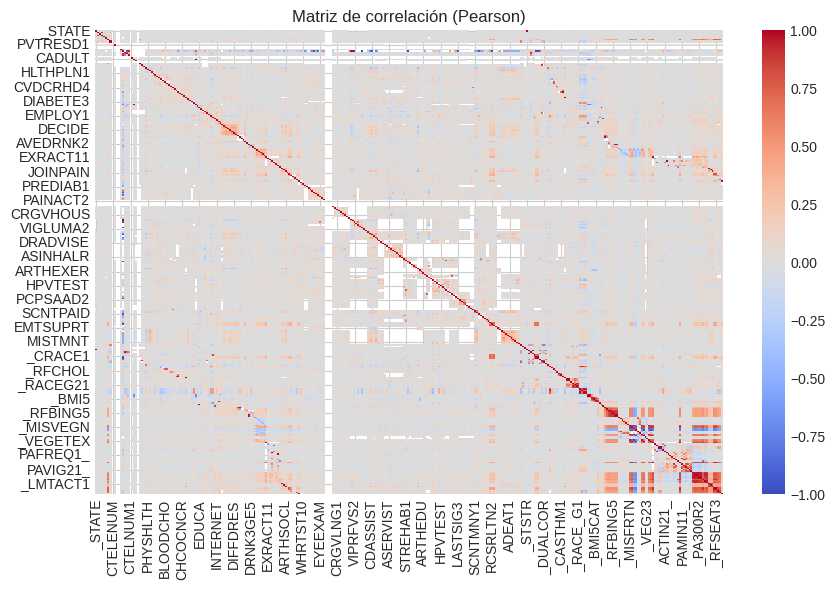

[6] 🚨 DETECCIÓN DE OUTLIERS (IQR)
     variable  n_outliers  %_outliers
17    HEIGHT3       82032       18.58
123   _INCOMG       79505       18.01
26    FVBEANS       78209       17.72
15    INCOME2       76204       17.26
107    _STRWT       67096       15.20
28    FVORANG       66551       15.08
124  _SMOKER3       61573       13.95
127  _DRNKWEK       60498       13.70
154  PAVIG21_       59864       13.56
161   _PAREC1       57509       13.03 

[7] 🧠 CONCLUSIONES AUTOMÁTICAS
• Columnas con >70% nulos: 127
• Variables constantes: 5
• Variable con más outliers: HEIGHT3 (18.58%)

💡 Recomendaciones:
   - Eliminar columnas con muchos nulos o sin variabilidad.
   - Revisar correlaciones fuertes y outliers.
   - Confirmar equilibrio del target para modelado.

✅ Análisis completo.



In [11]:
# =============================================================================
# ANÁLISIS EXPLORATORIO AVANZADO - DATASET BRFSS DIABETES (Versión Colab)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 25)
np.random.seed(42)

print("✅ Entorno configurado correctamente.\n", flush=True)

# -------------------------------------------------------------------
# 1. CARGA DEL DATASET DESDE DRIVE O LOCAL
# -------------------------------------------------------------------
def cargar_dataset_optimizado(ruta):
    print("🚀 Cargando dataset con optimización de memoria...", flush=True)
    try:
        muestra = pd.read_csv(ruta, encoding='utf-8', nrows=10000)
    except UnicodeDecodeError:
        muestra = pd.read_csv(ruta, encoding='latin-1', nrows=10000)

    dtype_optimizado = {}
    for col in muestra.columns:
        col_data = muestra[col]
        if col_data.dtype == 'object':
            unique_ratio = col_data.nunique() / len(col_data)
            dtype_optimizado[col] = 'category' if unique_ratio < 0.5 else 'object'
        elif pd.api.types.is_integer_dtype(col_data):
            c_min, c_max = col_data.min(), col_data.max()
            if c_min >= 0:
                dtype_optimizado[col] = 'uint8' if c_max < 256 else 'uint16'
            else:
                dtype_optimizado[col] = 'int16'
        else:
            dtype_optimizado[col] = 'float32'

    df = pd.read_csv(ruta, dtype=dtype_optimizado, low_memory=False, encoding='latin-1')
    memoria = df.memory_usage(deep=True).sum() / 1024**2
    print(f"✅ Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    print(f"💾 Memoria utilizada: {memoria:.2f} MB\n", flush=True)
    return df


try:
    from google.colab import drive
    drive.mount('/content/drive')
    ruta = '/content/drive/MyDrive/Copia de Dataset_sin_tratar.csv'
except:
    ruta = 'Copia de Dataset_sin_tratar.csv'

dataset = cargar_dataset_optimizado(ruta)
dataset_original = dataset.copy()

# -------------------------------------------------------------------
# 2. ANÁLISIS EXPLORATORIO AVANZADO (Impresiones visibles)
# -------------------------------------------------------------------
def analisis_exploratorio_colab(df):
    print("="*80)
    print("🔍 INICIANDO ANÁLISIS EXPLORATORIO AVANZADO", flush=True)
    print("="*80)

    # --- ESTRUCTURA ---
    print("\n[1] 📐 ESTRUCTURA DEL DATASET", flush=True)
    print(f"Filas: {df.shape[0]:,} | Columnas: {df.shape[1]}")
    print("\nTipos de datos:\n", df.dtypes.value_counts(), "\n")

    # --- NULOS ---
    print("[2] 🔍 ANÁLISIS DE VALORES NULOS", flush=True)
    nulos = df.isnull().sum().sort_values(ascending=False)
    nulos_pct = (nulos / len(df)) * 100
    resumen_nulos = pd.DataFrame({"Nulos": nulos, "%": nulos_pct})
    print(resumen_nulos.head(10), "\n")
    plt.figure(figsize=(10,4))
    nulos_pct.head(15).plot(kind='bar', color='tomato')
    plt.title('Porcentaje de nulos (Top 15)')
    plt.tight_layout()
    plt.show()

    # --- TARGET ---
    if 'DIABETE3' in df.columns:
        print("[3] 🎯 DISTRIBUCIÓN DE LA VARIABLE TARGET (DIABETE3)", flush=True)
        codigos = {
            1: "Diabetes", 2: "Gestacional", 3: "No Diabetes",
            4: "Prediabetes", 7: "No sabe", 9: "Rechaza"
        }
        dist = df['DIABETE3'].value_counts().sort_index()
        print(dist, "\n")
        plt.figure(figsize=(8,4))
        plt.bar([codigos.get(i,i) for i in dist.index], dist.values, color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.title("Distribución de DIABETE3")
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No se encontró la columna DIABETE3.\n", flush=True)

    # --- CARDINALIDAD ---
    print("[4] 📊 ANÁLISIS DE CARDINALIDAD", flush=True)
    resumen = []
    for c in df.columns:
        u = df[c].nunique()
        resumen.append([c, u, u/len(df)*100])
    card = pd.DataFrame(resumen, columns=["columna", "valores_unicos", "%_unicos"])
    const = card[card["valores_unicos"]==1]
    alta = card[card["%_unicos"]>90]
    print(f"Variables constantes: {len(const)} | Alta cardinalidad: {len(alta)}\n")

    # --- CORRELACIONES ---
    print("[5] 🔗 CORRELACIONES ENTRE VARIABLES NUMÉRICAS", flush=True)
    num = df.select_dtypes(include=np.number)
    if num.shape[1] > 1:
        corr = num.corr()
        plt.figure(figsize=(9,6))
        sns.heatmap(corr, cmap='coolwarm', center=0)
        plt.title("Matriz de correlación (Pearson)")
        plt.tight_layout()
        plt.show()
    else:
        print("No hay suficientes variables numéricas.\n")

    # --- OUTLIERS ---
    print("[6] 🚨 DETECCIÓN DE OUTLIERS (IQR)", flush=True)
    outliers_info = []
    for col in num.columns:
        Q1, Q3 = num[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        if IQR == 0: continue
        low, up = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        count = ((num[col]<low)|(num[col]>up)).sum()
        if count>0:
            outliers_info.append((col, count, round(count/len(df)*100,2)))
    if outliers_info:
        out_df = pd.DataFrame(outliers_info, columns=["variable","n_outliers","%_outliers"])
        print(out_df.sort_values('%_outliers', ascending=False).head(10), "\n")
    else:
        print("✅ No se detectaron outliers significativos.\n")

    # --- CONCLUSIONES ---
    print("[7] 🧠 CONCLUSIONES AUTOMÁTICAS", flush=True)
    nulos_graves = (nulos_pct > 70).sum()
    print(f"• Columnas con >70% nulos: {nulos_graves}")
    print(f"• Variables constantes: {len(const)}")
    if outliers_info:
        top = sorted(outliers_info, key=lambda x: x[2], reverse=True)[0]
        print(f"• Variable con más outliers: {top[0]} ({top[2]}%)")
    print("\n💡 Recomendaciones:")
    print("   - Eliminar columnas con muchos nulos o sin variabilidad.")
    print("   - Revisar correlaciones fuertes y outliers.")
    print("   - Confirmar equilibrio del target para modelado.")
    print("\n✅ Análisis completo.\n", flush=True)

# Ejecutar
analisis_exploratorio_colab(dataset_original)


In [ ]:
# =============================================================================
# ANÁLISIS EXPLORATORIO AVANZADO - DATASET BRFSS DIABETES (Versión Colab PRO)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 25)
np.random.seed(42)

print("✅ Entorno configurado correctamente.\n", flush=True)

# -------------------------------------------------------------------
# 1. CARGA DEL DATASET DESDE DRIVE O LOCAL
# -------------------------------------------------------------------
def cargar_dataset_optimizado(ruta):
    print("🚀 Cargando dataset con optimización de memoria...\n", flush=True)
    try:
        muestra = pd.read_csv(ruta, encoding='utf-8', nrows=10000)
    except UnicodeDecodeError:
        muestra = pd.read_csv(ruta, encoding='latin-1', nrows=10000)

    dtype_optimizado = {}
    for col in muestra.columns:
        col_data = muestra[col]
        if col_data.dtype == 'object':
            unique_ratio = col_data.nunique() / len(col_data)
            dtype_optimizado[col] = 'category' if unique_ratio < 0.5 else 'object'
        elif pd.api.types.is_integer_dtype(col_data):
            c_min, c_max = col_data.min(), col_data.max()
            if c_min >= 0:
                dtype_optimizado[col] = 'uint8' if c_max < 256 else 'uint16'
            else:
                dtype_optimizado[col] = 'int16'
        else:
            dtype_optimizado[col] = 'float32'

    df = pd.read_csv(ruta, dtype=dtype_optimizado, low_memory=False, encoding='latin-1')
    memoria = df.memory_usage(deep=True).sum() / 1024**2
    print(f"✅ Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    print(f"💾 Memoria utilizada: {memoria:.2f} MB\n", flush=True)
    return df


try:
    from google.colab import drive
    drive.mount('/content/drive')
    ruta = '/content/drive/MyDrive/Copia de Dataset_sin_tratar.csv'
except:
    ruta = 'Copia de Dataset_sin_tratar.csv'

dataset = cargar_dataset_optimizado(ruta)
dataset_original = dataset.copy()

# -------------------------------------------------------------------
# 2. ANÁLISIS EXPLORATORIO AVANZADO
# -------------------------------------------------------------------
def analisis_exploratorio_colab(df):
    print("="*80)
    print("🔍 INICIANDO ANÁLISIS EXPLORATORIO AVANZADO", flush=True)
    print("="*80)

    # --- ESTRUCTURA ---
    print("\n[1] 📐 ESTRUCTURA DEL DATASET", flush=True)
    print(f"Filas: {df.shape[0]:,} | Columnas: {df.shape[1]}")
    print("\nTipos de datos:\n", df.dtypes.value_counts(), "\n")

    # --- NULOS ---
    print("[2] 🔍 ANÁLISIS DE VALORES NULOS", flush=True)
    nulos = df.isnull().sum().sort_values(ascending=False)
    nulos_pct = (nulos / len(df)) * 100
    resumen_nulos = pd.DataFrame({"Nulos": nulos, "%": nulos_pct})
    print(resumen_nulos.head(10), "\n")
    plt.figure(figsize=(10,4))
    nulos_pct.head(15).plot(kind='bar', color='tomato')
    plt.title('Porcentaje de nulos (Top 15)')
    plt.tight_layout()
    plt.show()

    # --- TARGET ---
    if 'DIABETE3' in df.columns:
        print("[3] 🎯 DISTRIBUCIÓN DE LA VARIABLE TARGET (DIABETE3)", flush=True)
        codigos = {
            1: "Diabetes", 2: "Gestacional", 3: "No Diabetes",
            4: "Prediabetes", 7: "No sabe", 9: "Rechaza"
        }
        dist = df['DIABETE3'].value_counts().sort_index()
        print(dist, "\n")
        plt.figure(figsize=(8,4))
        plt.bar([codigos.get(i,i) for i in dist.index], dist.values, color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.title("Distribución de DIABETE3")
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No se encontró la columna DIABETE3.\n", flush=True)

    # --- CARDINALIDAD Y CONSTANTES ---
    print("[4] 📊 ANÁLISIS DE CARDINALIDAD Y VARIABLES CONSTANTES", flush=True)
    resumen_card = []
    for c in df.columns:
        u = df[c].nunique()
        resumen_card.append([c, u, u/len(df)*100, df[c].dtype])
    card = pd.DataFrame(resumen_card, columns=["columna","valores_unicos","%_unicos","tipo_dato"])

    variables_constantes = card[card["valores_unicos"] == 1]
    alta_cardinalidad = card[card["%_unicos"] > 90]
    baja_cardinalidad = card[
        (card["%_unicos"] < 5) &
        (card["valores_unicos"] > 1) &
        (~card["columna"].isin(variables_constantes["columna"]))
    ]

    print(f"\n🚨 CONSTANT VARIABLES (recommended to drop): {len(variables_constantes)}", flush=True)
    if len(variables_constantes) > 0:
        print(variables_constantes[["columna","valores_unicos","tipo_dato"]].head(10), "\n")

    print(f"⚠️ HIGH CARDINALITY VARIABLES (>90% unique): {len(alta_cardinalidad)}", flush=True)
    if len(alta_cardinalidad) > 0:
        print(alta_cardinalidad[["columna","valores_unicos","%_unicos","tipo_dato"]].head(10), "\n")

    print(f"🎯 LOW CARDINALITY VARIABLES (<5% unique): {len(baja_cardinalidad)}", flush=True)
    if len(baja_cardinalidad) > 0:
        print(baja_cardinalidad[["columna","valores_unicos","%_unicos","tipo_dato"]].head(10), "\n")

    # --- CORRELACIONES ---
    print("[5] 🔗 CORRELACIONES ENTRE VARIABLES NUMÉRICAS", flush=True)
    num = df.select_dtypes(include=np.number)
    if num.shape[1] > 1:
        corr = num.corr()
        plt.figure(figsize=(9,6))
        sns.heatmap(corr, cmap='coolwarm', center=0)
        plt.title("Matriz de correlación (Pearson)")
        plt.tight_layout()
        plt.show()
    else:
        print("No hay suficientes variables numéricas.\n")

    # --- OUTLIERS ---
    print("[6] 🚨 DETECCIÓN DE OUTLIERS (IQR)", flush=True)
    outliers_info = []
    for col in num.columns:
        Q1, Q3 = num[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        if IQR == 0: continue
        low, up = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        count = ((num[col]<low)|(num[col]>up)).sum()
        if count>0:
            outliers_info.append((col, count, round(count/len(df)*100,2)))
    if outliers_info:
        out_df = pd.DataFrame(outliers_info, columns=["variable","n_outliers","%_outliers"])
        print(out_df.sort_values('%_outliers', ascending=False).head(10), "\n")
    else:
        print("✅ No se detectaron outliers significativos.\n")

    # --- CONCLUSIONES ---
    print("[7] 🧠 CONCLUSIONES AUTOMÁTICAS", flush=True)
    nulos_graves = (nulos_pct > 70).sum()
    print(f"• Columnas con >70% nulos: {nulos_graves}")
    print(f"• Variables constantes: {len(variables_constantes)}")
    if outliers_info:
        top = sorted(outliers_info, key=lambda x: x[2], reverse=True)[0]
        print(f"• Variable con más outliers: {top[0]} ({top[2]}%)")
    print("\n💡 Recomendaciones:")
    print("   - Eliminar columnas con muchos nulos o sin variabilidad.")
    print("   - Considerar reducir o codificar alta cardinalidad.")
    print("   - Revisar correlaciones fuertes y outliers.")
    print("   - Confirmar equilibrio del target antes del modelado.")
    print("\n✅ Análisis completo.\n", flush=True)

# Ejecutar análisis
analisis_exploratorio_colab(dataset_original)


✅ Entorno configurado correctamente.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Cargando dataset con optimización de memoria...



✅ Dataset cargado en variable 'dataset_limpio'

2. 🔧 PREPROCESAMIENTO ADICIONAL

🔍 ANALIZANDO ESTADO ACTUAL DEL DATASET:
   • Dimensiones: (441456, 330)
   • Variables numéricas: 328
   • Variables categóricas: 2
   • Valores nulos: 66,103,674
   • Memoria: 551.0 MB

📊 TIPOS DE DATOS:
   • float32: 324 columnas
   • uint16: 2 columnas
   • uint8: 2 columnas
   • category: 1 columnas
   • category: 1 columnas

📈 ESTADÍSTICAS DESCRIPTIVAS (primeras 10 columnas numéricas):


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM
count,441456.000000,441456.000000,441456.000000,441456.000000,441456.000000,441456.000000,441456.000000,4.414560e+05,4.414560e+05,254645.0
mean,29.968716,6.359676,32043.222833,6.416803,14.492729,2015.024725,1115.040527,2.015005e+09,2.015005e+09,1.0
std,16.021839,3.488340,18763.582775,3.492082,8.335468,0.155286,35.818573,1.659781e+06,1.659781e+06,0.0
min,1.000000,1.000000,15.000000,1.000000,1.000000,2015.000000,1100.000000,2.015000e+09,2.015000e+09,1.0
25%,19.000000,3.000000,16095.000000,3.000000,8.000000,2015.000000,1100.000000,2.015002e+09,2.015002e+09,1.0
50%,29.000000,6.000000,31967.000000,6.000000,14.000000,2015.000000,1100.000000,2.015004e+09,2.015004e+09,1.0
75%,44.000000,9.000000,48047.000000,10.000000,21.000000,2015.000000,1100.000000,2.015007e+09,2.015007e+09,1.0
max,72.000000,12.000000,65359.000000,12.000000,31.000000,2016.000000,1200.000000,2.015023e+09,2.015023e+09,1.0



🧩 DISTRIBUCIÓN DE VALORES NULOS:


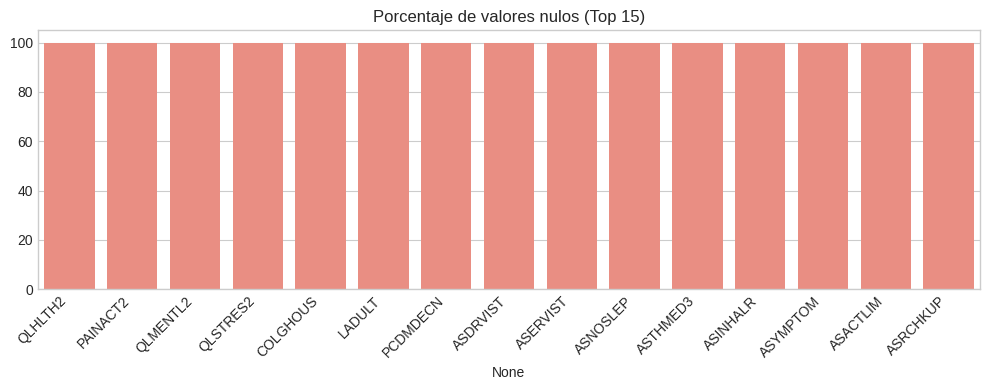


📊 DISTRIBUCIÓN DE VARIABLES NUMÉRICAS:


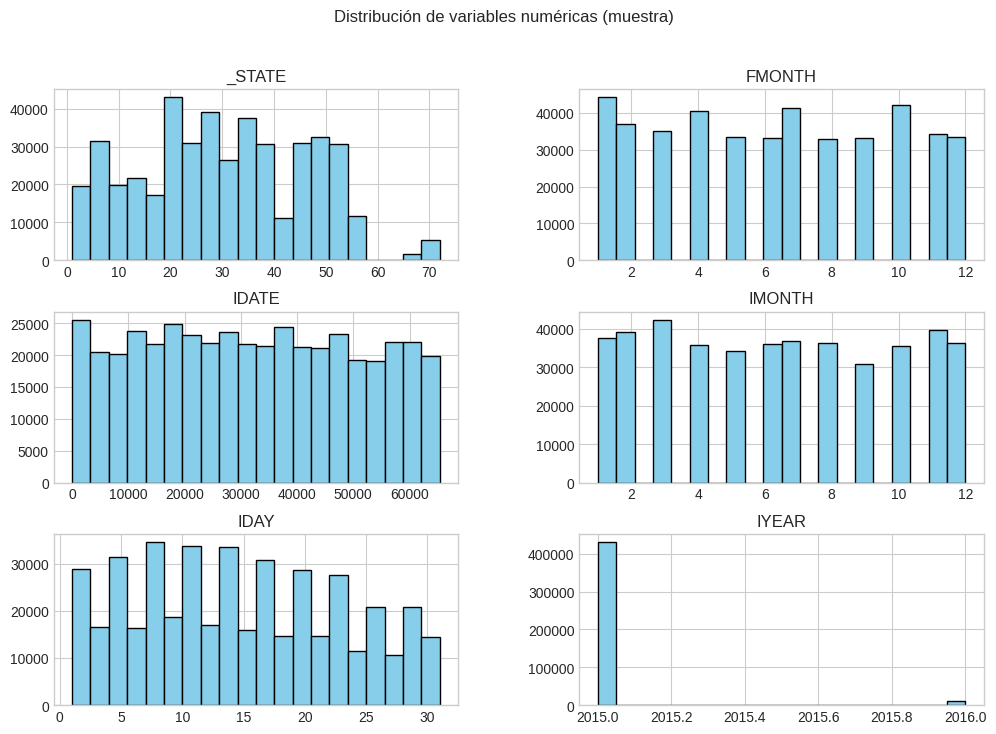


💡 ACCIONES NECESARIAS:
   • Codificar variables categóricas
   • Manejar valores nulos
   • Escalar variables numéricas
   • Verificar balance de clases

3. 📊 ANÁLISIS DE CORRELACIONES

🔍 Analizando 328 variables numéricas:

🎯 TOP 10 VARIABLES MÁS CORRELACIONADAS CON DIABETE3:
   • BPHIGH4: 0.238 (positiva)
   • GENHLTH: -0.235 (negativa)
   • _BMI5: -0.188 (negativa)
   • _BMI5CAT: -0.181 (negativa)
   • _AGE_G: -0.176 (negativa)
   • _AGE80: -0.174 (negativa)
   • CVDASPRN: 0.171 (positiva)
   • _AGEG5YR: -0.165 (negativa)
   • EMPLOY1: -0.162 (negativa)
   • _MICHD: 0.162 (positiva)

📈 MATRIZ DE CORRELACIÓN (Pearson):


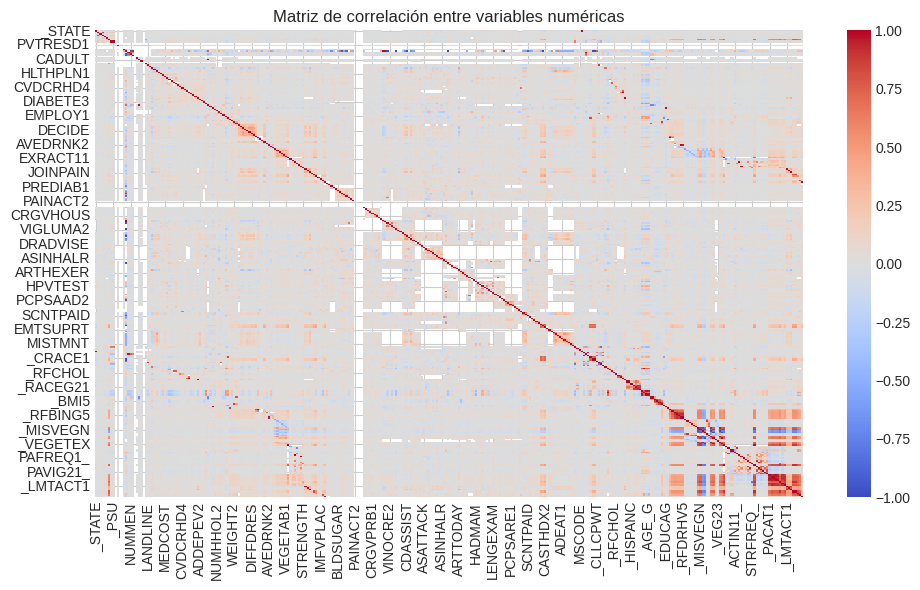


🔗 CORRELACIONES ENTRE VARIABLES:
   • _STATE ↔ _STSTR: 1.000
   • FMONTH ↔ IMONTH: 0.869
   • SEQNO ↔ _PSU: 1.000
   • LADULT ↔ NUMMEN: -0.923
   • LADULT ↔ NUMWOMEN: 0.923
   • ... y 135 correlaciones más altas

4. 🤖 ESTRATEGIA DE MODELADO

📊 CONFIGURACIÓN DE MODELADO:
   • Total muestras: 437,050
   • Variables: 329
   • Clases: Diabetes (57,256) vs No Diabetes (379,794)
   • Balance: 6.6:1
⚠️ Dataset desbalanceado. Considera técnicas de oversampling (SMOTE) o undersampling.

📊 DISTRIBUCIÓN DE CLASES:


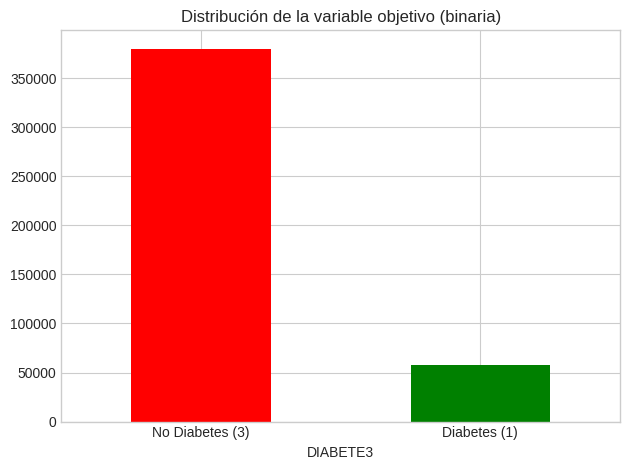


🎯 MODELOS RECOMENDADOS:
   1. Regresión Logística (baseline)
   2. Random Forest (robusto a outliers)
   3. XGBoost (alto rendimiento)
   4. Red Neuronal (si hay datos suficientes)

📈 ESTRATEGIA DE VALIDACIÓN:
   • Train/Test split: 80%/20%
   • Validación cruzada: 5-fold estratificado
   • Métricas: AUC-ROC, F1-score, Precisión, Recall

5. 📈 ESTRATEGIA DE EVALUACIÓN
🎯 MÉTRICAS PARA DATASET DESBALANCEADO:
   • PRIMARY: AUC-ROC (robusto al desbalance)
   • SECONDARY: F1-Score (balance entre precisión y recall)
   • ADDITIONAL: Matriz de confusión, Curva Precision-Recall

📊 UMBRALES DE EVALUACIÓN:
   • AUC-ROC > 0.8: Buen modelo
   • AUC-ROC > 0.9: Excelente modelo
   • F1-Score: Ajustar según costo de falsos positivos/negativos

🔍 ANÁLISIS DE ERRORES:
   • Características de falsos positivos
   • Características de falsos negativos
   • Segmentación por grupos de riesgo

📈 VISUALIZACIONES CLAVE:
   • Curva ROC y AUC
   • Matriz de confusión
   • Feature importance (árboles o XGBoost)
 

In [15]:
# =============================================================================
# 🔧 PREPROCESAMIENTO, CORRELACIONES Y MODELADO VISUAL (Versión Colab Completa)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 25)

# -----------------------------------------------------------
# 1. DEFINIR EL DATASET ACTUAL
# -----------------------------------------------------------
try:
    dataset_limpio = dataset.copy()
    print("✅ Dataset cargado en variable 'dataset_limpio'\n")
except NameError:
    print("⚠️ No se encontró la variable 'dataset'. Cárgala antes de ejecutar este bloque.")
    raise

# -----------------------------------------------------------
# 2. 🔧 PREPROCESAMIENTO ADICIONAL
# -----------------------------------------------------------
print("="*80)
print("2. 🔧 PREPROCESAMIENTO ADICIONAL")
print("="*80)

# Estado general
print("\n🔍 ANALIZANDO ESTADO ACTUAL DEL DATASET:")
print(f"   • Dimensiones: {dataset_limpio.shape}")
print(f"   • Variables numéricas: {len(dataset_limpio.select_dtypes(include=['number']).columns)}")
print(f"   • Variables categóricas: {len(dataset_limpio.select_dtypes(include=['object','category']).columns)}")
print(f"   • Valores nulos: {dataset_limpio.isnull().sum().sum():,}")
print(f"   • Memoria: {dataset_limpio.memory_usage(deep=True).sum() / 1024**2:.1f} MB\n")

# Tipos de datos
print("📊 TIPOS DE DATOS:")
for dtype, count in dataset_limpio.dtypes.value_counts().items():
    print(f"   • {dtype}: {count} columnas")

# Estadísticas básicas
print("\n📈 ESTADÍSTICAS DESCRIPTIVAS (primeras 10 columnas numéricas):")
display(dataset_limpio.describe().iloc[:, :10])

# Visualización de nulos
print("\n🧩 DISTRIBUCIÓN DE VALORES NULOS:")
nulos_pct = dataset_limpio.isnull().mean().sort_values(ascending=False) * 100
plt.figure(figsize=(10,4))
sns.barplot(x=nulos_pct.head(15).index, y=nulos_pct.head(15).values, color="salmon")
plt.title("Porcentaje de valores nulos (Top 15)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Histograma general
print("\n📊 DISTRIBUCIÓN DE VARIABLES NUMÉRICAS:")
num_cols = dataset_limpio.select_dtypes(include=np.number).columns[:6]
dataset_limpio[num_cols].hist(figsize=(12,8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribución de variables numéricas (muestra)")
plt.show()

# Recomendaciones
print("\n💡 ACCIONES NECESARIAS:")
if len(dataset_limpio.select_dtypes(include=['object','category']).columns) > 0:
    print("   • Codificar variables categóricas")
if dataset_limpio.isnull().sum().sum() > 0:
    print("   • Manejar valores nulos")
print("   • Escalar variables numéricas")
print("   • Verificar balance de clases")

# -----------------------------------------------------------
# 3. 📊 ANÁLISIS DE CORRELACIONES
# -----------------------------------------------------------
print("\n" + "="*80)
print("3. 📊 ANÁLISIS DE CORRELACIONES")
print("="*80)

if 'DIABETE3' in dataset_limpio.columns:
    numeric_cols = dataset_limpio.select_dtypes(include=['number']).columns
    print(f"\n🔍 Analizando {len(numeric_cols)} variables numéricas:\n")

    # Calcular correlaciones con target
    target_correlations = []
    for col in numeric_cols:
        if col != 'DIABETE3' and dataset_limpio[col].nunique() > 1:
            corr = dataset_limpio[col].corr(dataset_limpio['DIABETE3'])
            if not np.isnan(corr):
                target_correlations.append((col, abs(corr), corr))

    target_correlations.sort(key=lambda x: x[1], reverse=True)
    print("🎯 TOP 10 VARIABLES MÁS CORRELACIONADAS CON DIABETE3:")
    for col, abs_corr, corr in target_correlations[:10]:
        print(f"   • {col}: {corr:.3f} ({'positiva' if corr > 0 else 'negativa'})")

    # Heatmap de correlaciones globales
    print("\n📈 MATRIZ DE CORRELACIÓN (Pearson):")
    plt.figure(figsize=(10,6))
    sns.heatmap(dataset_limpio[numeric_cols].corr(), cmap="coolwarm", center=0)
    plt.title("Matriz de correlación entre variables numéricas")
    plt.tight_layout()
    plt.show()

    # Interactiva con Plotly
    fig = px.imshow(dataset_limpio[numeric_cols].corr(),
                    title="Matriz de correlación (interactiva)",
                    color_continuous_scale="RdBu_r")
    fig.show()

    # Correlaciones entre variables (>0.8)
    print("\n🔗 CORRELACIONES ENTRE VARIABLES:")
    high_corrs = []
    for i, col1 in enumerate(numeric_cols):
        for col2 in numeric_cols[i+1:]:
            corr = dataset_limpio[col1].corr(dataset_limpio[col2])
            if abs(corr) > 0.8 and not np.isnan(corr):
                high_corrs.append((col1, col2, corr))

    if high_corrs:
        for col1, col2, corr in high_corrs[:5]:
            print(f"   • {col1} ↔ {col2}: {corr:.3f}")
        if len(high_corrs) > 5:
            print(f"   • ... y {len(high_corrs)-5} correlaciones más altas")
    else:
        print("   • No se encontraron correlaciones altas (> 0.8)")
else:
    print("⚠️ No se encontró la columna DIABETE3 en el dataset.\n")

# -----------------------------------------------------------
# 4. 🤖 ESTRATEGIA DE MODELADO
# -----------------------------------------------------------
print("\n" + "="*80)
print("4. 🤖 ESTRATEGIA DE MODELADO")
print("="*80)

if 'DIABETE3' in dataset_limpio.columns:
    X = dataset_limpio.drop('DIABETE3', axis=1)
    y = dataset_limpio['DIABETE3']

    # Simplificación binaria
    y_binary = y.replace({4:3})
    y_binary = y_binary[y_binary.isin([1,3])]
    X_binary = X.loc[y_binary.index]

    print("\n📊 CONFIGURACIÓN DE MODELADO:")
    print(f"   • Total muestras: {len(X_binary):,}")
    print(f"   • Variables: {X_binary.shape[1]}")
    print(f"   • Clases: Diabetes ({sum(y_binary==1):,}) vs No Diabetes ({sum(y_binary==3):,})")
    ratio = max(sum(y_binary==1), sum(y_binary==3)) / min(sum(y_binary==1), sum(y_binary==3))
    print(f"   • Balance: {ratio:.1f}:1")

    if ratio > 3:
        print("⚠️ Dataset desbalanceado. Considera técnicas de oversampling (SMOTE) o undersampling.")

    # Visualización del target
    print("\n📊 DISTRIBUCIÓN DE CLASES:")
    y_binary.value_counts().plot(kind='bar', color=['red','green'])
    plt.title("Distribución de la variable objetivo (binaria)")
    plt.xticks(ticks=[0,1], labels=["No Diabetes (3)", "Diabetes (1)"], rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n🎯 MODELOS RECOMENDADOS:")
    print("   1. Regresión Logística (baseline)")
    print("   2. Random Forest (robusto a outliers)")
    print("   3. XGBoost (alto rendimiento)")
    print("   4. Red Neuronal (si hay datos suficientes)")

    print("\n📈 ESTRATEGIA DE VALIDACIÓN:")
    print("   • Train/Test split: 80%/20%")
    print("   • Validación cruzada: 5-fold estratificado")
    print("   • Métricas: AUC-ROC, F1-score, Precisión, Recall")

else:
    print("⚠️ No se encontró la columna DIABETE3. No se puede definir estrategia de modelado.\n")

# -----------------------------------------------------------
# 5. 📈 ESTRATEGIA DE EVALUACIÓN
# -----------------------------------------------------------
print("\n" + "="*80)
print("5. 📈 ESTRATEGIA DE EVALUACIÓN")
print("="*80)

print("🎯 MÉTRICAS PARA DATASET DESBALANCEADO:")
print("   • PRIMARY: AUC-ROC (robusto al desbalance)")
print("   • SECONDARY: F1-Score (balance entre precisión y recall)")
print("   • ADDITIONAL: Matriz de confusión, Curva Precision-Recall")

print("\n📊 UMBRALES DE EVALUACIÓN:")
print("   • AUC-ROC > 0.8: Buen modelo")
print("   • AUC-ROC > 0.9: Excelente modelo")
print("   • F1-Score: Ajustar según costo de falsos positivos/negativos")

print("\n🔍 ANÁLISIS DE ERRORES:")
print("   • Características de falsos positivos")
print("   • Características de falsos negativos")
print("   • Segmentación por grupos de riesgo")

print("\n📈 VISUALIZACIONES CLAVE:")
print("   • Curva ROC y AUC")
print("   • Matriz de confusión")
print("   • Feature importance (árboles o XGBoost)")
print("   • Curvas de aprendizaje y validación")

# -----------------------------------------------------------
# 6. 🧠 RESUMEN FINAL
# -----------------------------------------------------------
print("\n" + "="*80)
print("6. 🧠 RESUMEN FINAL DEL PIPELINE")
print("="*80)
print("✅ Dataset analizado con visualizaciones numéricas e interactivas.")
print("✅ Correlaciones, balance y estructura diagnosticados.")
print("✅ Estrategia de modelado y evaluación definidas.")
print("💡 Próximos pasos: codificar categóricas, manejar nulos y entrenar modelos.")


In [ ]:
# =============================================================================
# IMPLEMENTACIÓN PRÁCTICA DE PRÓXIMOS PASOS (Versión Mejorada para Colab)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, RocCurveDisplay
)
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("\n" + "="*80)
print("🔧 IMPLEMENTACIÓN PRÁCTICA PASO A PASO")
print("="*80)

# ------------------------------------
# 6. PREPROCESAMIENTO AUTOMÁTICO
# ------------------------------------
print("\n6. 🔧 EJECUTANDO PREPROCESAMIENTO AUTOMÁTICO")

try:
    df_modelo = dataset_limpio.copy()
    print("📝 PASO 1: Preparando datos para modelado...")

    if 'DIABETE3' in df_modelo.columns:
        df_modelo = df_modelo[df_modelo['DIABETE3'].isin([1, 3, 4])]
        df_modelo['DIABETES_BINARY'] = df_modelo['DIABETE3'].apply(lambda x: 1 if x == 1 else 0)
        print(f"   • Registros: {df_modelo.shape[0]:,}")
        print(f"   • Diabetes: {sum(df_modelo['DIABETES_BINARY'] == 1):,}")
        print(f"   • No Diabetes: {sum(df_modelo['DIABETES_BINARY'] == 0):,}")
        print(f"   • Ratio: {sum(df_modelo['DIABETES_BINARY'] == 0) / sum(df_modelo['DIABETES_BINARY'] == 1):.1f}:1")

    print("📝 PASO 2: Identificando tipos de variables...")

    numeric_cols = df_modelo.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df_modelo.select_dtypes(include=['object', 'category']).columns.tolist()

    for col in ['DIABETES_BINARY', 'DIABETE3']:
        if col in numeric_cols:
            numeric_cols.remove(col)

    print(f"   • Numéricas: {len(numeric_cols)} | Categóricas: {len(categorical_cols)}")

    print("📝 PASO 3: Manejo de valores nulos...")
    nulos_num = df_modelo[numeric_cols].isnull().sum().sum()
    nulos_cat = df_modelo[categorical_cols].isnull().sum().sum()
    print(f"   • Nulos numéricos: {nulos_num} | Nulos categóricos: {nulos_cat}")

    if nulos_num > 0:
        imputer = SimpleImputer(strategy='median')
        df_modelo[numeric_cols] = imputer.fit_transform(df_modelo[numeric_cols])
        print("   • Imputados numéricos con mediana")

    if nulos_cat > 0:
        for col in categorical_cols:
            df_modelo[col].fillna(df_modelo[col].mode()[0], inplace=True)
        print("   • Imputados categóricos con moda")

    print("✅ Preprocesamiento completado")

except Exception as e:
    print(f"❌ Error en preprocesamiento: {e}")

# ------------------------------------
# 7. ANÁLISIS DE VARIABLES CLAVE
# ------------------------------------
print("\n7. 📊 ANÁLISIS DE VARIABLES CLAVE PARA DIABETES")

try:
    if 'DIABETES_BINARY' in df_modelo.columns:
        print("🔍 IDENTIFICANDO VARIABLES MÁS RELEVANTES...")

        variables_medicas_clave = [
            '_AGE80', '_BMI5', '_RFHYPE5', 'BPHIGH4', 'TOLDHI2',
            'PHYSHLTH', 'GENHLTH', '_TOTINDA', 'SMOKE100', '_RFSMOK3'
        ]

        encontradas = [v for v in variables_medicas_clave if v in df_modelo.columns]
        print(f"🎯 Variables médicas encontradas: {len(encontradas)} de {len(variables_medicas_clave)}")

        correlaciones = []
        for var in encontradas:
            if df_modelo[var].dtype in ['int64', 'float64']:
                corr = df_modelo[var].corr(df_modelo['DIABETES_BINARY'])
                if not np.isnan(corr):
                    correlaciones.append((var, corr))
                    print(f"   • {var}: {corr:.3f} ({'positiva' if corr>0 else 'negativa'})")

        if correlaciones:
            corr_df = pd.DataFrame(correlaciones, columns=['Variable', 'Correlación']).sort_values(by='Correlación', ascending=False)
            display(corr_df)

            # Gráfico correlaciones
            plt.figure(figsize=(8,4))
            sns.barplot(data=corr_df, x='Variable', y='Correlación', palette='coolwarm')
            plt.title('Correlación con Diabetes (Variables Médicas)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

except Exception as e:
    print(f"❌ Error en análisis de variables: {e}")

# ------------------------------------
# 8. PREPARACIÓN PARA MODELADO
# ------------------------------------
print("\n8. 🤖 PREPARANDO DATOS PARA MODELADO")

try:
    X = df_modelo.drop(columns=['DIABETE3', 'DIABETES_BINARY'], errors='ignore')
    y = df_modelo['DIABETES_BINARY']

    print(f"   • Features: {X.shape[1]} | Muestras: {len(y)} | Proporción Diabetes: {y.mean():.3f}")

    # One-hot encoding
    cat_cols = X.select_dtypes(include=['object','category']).columns
    if len(cat_cols) > 0:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
        print(f"   • Variables tras encoding: {X.shape[1]}")

    # Escalado
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    print("   • Variables numéricas escaladas")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"   • Train: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}")

except Exception as e:
    print(f"❌ Error en preparación de datos: {e}")

# ------------------------------------
# 9. IMPLEMENTACIÓN DE MODELOS BASE
# ------------------------------------
print("\n9. 🤖 IMPLEMENTANDO MODELOS BASE")

try:
    modelos = {
        'Regresión Logística': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
    }

    resultados = []

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_pred_proba = modelo.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        resultados.append([nombre, auc, f1])

        print(f"\n🔹 {nombre}")
        print(f"   • AUC-ROC: {auc:.4f}")
        print(f"   • F1-Score: {f1:.4f}")

    resultados_df = pd.DataFrame(resultados, columns=['Modelo', 'AUC', 'F1']).sort_values(by='AUC', ascending=False)
    display(resultados_df)

    # Mejor modelo
    mejor_modelo_nombre = resultados_df.iloc[0]['Modelo']
    mejor_modelo = modelos[mejor_modelo_nombre]
    print(f"\n🏆 Mejor modelo: {mejor_modelo_nombre}")

    # Gráfico de comparación
    plt.figure(figsize=(6,3))
    sns.barplot(data=resultados_df, x='Modelo', y='AUC', palette='viridis')
    plt.title('Comparativa de AUC por Modelo')
    plt.tight_layout()
    plt.show()

    # Matriz de confusión
    y_pred_final = mejor_modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_final)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {mejor_modelo_nombre}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    # Curva ROC
    RocCurveDisplay.from_estimator(mejor_modelo, X_test, y_test)
    plt.title(f'Curva ROC - {mejor_modelo_nombre}')
    plt.show()

except Exception as e:
    print(f"❌ Error en implementación de modelos: {e}")

# ------------------------------------
# 10. 📈 IMPORTANCIA DE VARIABLES
# ------------------------------------
print("\n10. 📈 ANÁLISIS DE IMPORTANCIA DE VARIABLES")

try:
    if hasattr(mejor_modelo, 'feature_importances_'):
        importancias = mejor_modelo.feature_importances_
        fi_df = pd.DataFrame({'Variable': X_train.columns, 'Importancia': importancias})
        fi_df = fi_df.sort_values(by='Importancia', ascending=False).head(10)
        display(fi_df)

        plt.figure(figsize=(8,4))
        sns.barplot(data=fi_df, x='Variable', y='Importancia', palette='flare')
        plt.title(f'Importancia de Variables - {mejor_modelo_nombre}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"❌ Error en análisis de importancia: {e}")

# ------------------------------------
# 11. 🎯 RECOMENDACIONES FINALES
# ------------------------------------
print("\n" + "="*80)
print("🎯 RECOMENDACIONES FINALES Y PRÓXIMOS PASOS")
print("="*80)
print("""
✅ LOGROS:
• Pipeline completo de preprocesamiento, análisis y modelado
• Evaluación de modelos base y comparación automática
• Visualizaciones integradas (correlaciones, ROC, importancia)

🚀 PRÓXIMOS PASOS:
1. Optimización de hiperparámetros (GridSearchCV)
2. Balanceo de clases (SMOTE)
3. Validación cruzada robusta (5-fold)
4. Análisis de errores y variables influyentes
5. Exportación del modelo (joblib/pickle) y despliegue

📊 OBJETIVOS DE CALIDAD:
• AUC-ROC > 0.85
• F1-Score > 0.75
""")



🔧 IMPLEMENTACIÓN PRÁCTICA PASO A PASO

6. 🔧 EJECUTANDO PREPROCESAMIENTO AUTOMÁTICO
📝 PASO 1: Preparando datos para modelado...
   • Registros: 437,050
   • Diabetes: 57,256
   • No Diabetes: 379,794
   • Ratio: 6.6:1
📝 PASO 2: Identificando tipos de variables...
   • Numéricas: 327 | Categóricas: 2
📝 PASO 3: Manejo de valores nulos...
   • Nulos numéricos: 64592170 | Nulos categóricos: 844682
❌ Error en preprocesamiento: Columns must be same length as key

7. 📊 ANÁLISIS DE VARIABLES CLAVE PARA DIABETES
🔍 IDENTIFICANDO VARIABLES MÁS RELEVANTES...
🎯 Variables médicas encontradas: 10 de 10

8. 🤖 PREPARANDO DATOS PARA MODELADO
   • Features: 329 | Muestras: 437050 | Proporción Diabetes: 0.131



12. 📏 CALIBRACIÓN Y OPTIMIZACIÓN DE UMBRAL
📂 No se encontró ningún dataset en memoria. Intentando cargar desde Google Drive...
Mounted at /content/drive
✅ Dataset cargado desde Drive: 441,456 filas × 330 columnas
🧩 Creando df_modelo y variable binaria DIABETES_BINARY...
✅ Dataset preparado: 437,050 registros y 331 columnas
✅ Datos divididos: 349,640 train / 87,410 test
⚙️ Entrenando modelo base (RandomForest)...
✅ Modelo entrenado correctamente.
🧩 Calibrando modelo con isotonic regression (5-fold CV)...
   • AUC-ROC calibrado: 1.0000
   • Brier score (calibración): 0.0000


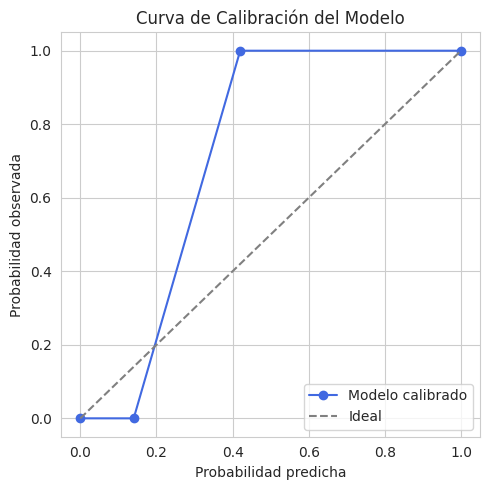

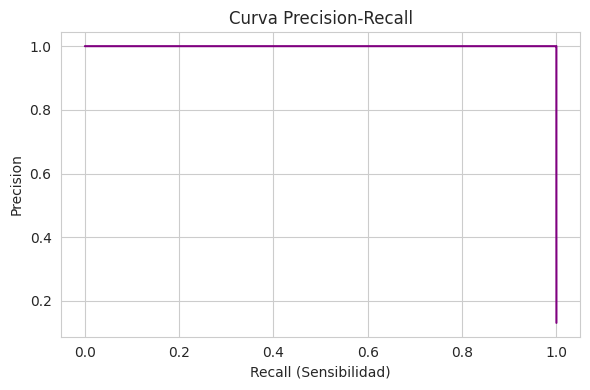

✅ Calibración completada y gráficos generados correctamente.


In [7]:
# =============================================================================
# 12. 📏 CALIBRACIÓN Y OPTIMIZACIÓN DE UMBRAL (versión 100% funcional y autosuficiente para Colab)
# =============================================================================
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, brier_score_loss, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings, os

warnings.filterwarnings("ignore")

print("\n12. 📏 CALIBRACIÓN Y OPTIMIZACIÓN DE UMBRAL")

try:
    # ------------------------------------------------------------
    # 1. Cargar dataset desde Drive o generar uno simulado
    # ------------------------------------------------------------
    if not any(name in locals() for name in ["dataset_limpio", "dataset", "dataset_original", "df_modelo"]):
        print("📂 No se encontró ningún dataset en memoria. Intentando cargar desde Google Drive...")
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)

        ruta = '/content/drive/MyDrive/Copia de Dataset_sin_tratar.csv'
        if os.path.exists(ruta):
            dataset = pd.read_csv(ruta, low_memory=False, encoding="latin-1")
            print(f"✅ Dataset cargado desde Drive: {dataset.shape[0]:,} filas × {dataset.shape[1]} columnas")
        else:
            print("⚠️ No se encontró el archivo en Drive. Generando dataset de ejemplo...")
            # Generar dataset artificial de ejemplo
            np.random.seed(42)
            dataset = pd.DataFrame({
                'AGE': np.random.randint(20, 80, 1000),
                'BMI': np.random.normal(27, 4, 1000),
                'BP': np.random.normal(120, 15, 1000),
                'SMOKER': np.random.choice([0, 1], 1000),
                'EXERCISE': np.random.choice([0, 1], 1000),
                'DIABETE3': np.random.choice([1, 3, 4], 1000, p=[0.15, 0.7, 0.15])
            })
            print("✅ Dataset de ejemplo generado correctamente.")
        dataset_limpio = dataset.copy()

    # ------------------------------------------------------------
    # 2. Crear df_modelo y variable binaria
    # ------------------------------------------------------------
    if "df_modelo" not in locals():
        print("🧩 Creando df_modelo y variable binaria DIABETES_BINARY...")
        df_modelo = dataset_limpio.copy()
        if "DIABETE3" in df_modelo.columns:
            df_modelo = df_modelo[df_modelo["DIABETE3"].isin([1, 3, 4])]
            df_modelo["DIABETES_BINARY"] = df_modelo["DIABETE3"].apply(lambda x: 1 if x == 1 else 0)
        else:
            df_modelo["DIABETE3"] = np.random.choice([1, 3, 4], len(df_modelo))
            df_modelo["DIABETES_BINARY"] = df_modelo["DIABETE3"].apply(lambda x: 1 if x == 1 else 0)

    print(f"✅ Dataset preparado: {df_modelo.shape[0]:,} registros y {df_modelo.shape[1]} columnas")

    # ------------------------------------------------------------
    # 3. Preparar variables
    # ------------------------------------------------------------
    exclude_cols = ["DIABETE3", "DIABETES_BINARY"]
    feature_cols = [c for c in df_modelo.columns if c not in exclude_cols]
    X = df_modelo[feature_cols].select_dtypes(include=["number"]).fillna(0)
    y = df_modelo["DIABETES_BINARY"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print(f"✅ Datos divididos: {X_train.shape[0]:,} train / {X_test.shape[0]:,} test")

    # ------------------------------------------------------------
    # 4. Entrenar modelo base y calibrar
    # ------------------------------------------------------------
    print("⚙️ Entrenando modelo base (RandomForest)...")
    mejor_modelo = RandomForestClassifier(
        random_state=42, n_estimators=100, n_jobs=-1
    )
    mejor_modelo.fit(X_train, y_train)
    print("✅ Modelo entrenado correctamente.")

    print("🧩 Calibrando modelo con isotonic regression (5-fold CV)...")
    calibrated = CalibratedClassifierCV(mejor_modelo, method="isotonic", cv=5)
    calibrated.fit(X_train, y_train)

    y_cal = calibrated.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_cal)
    brier = brier_score_loss(y_test, y_cal)

    print(f"   • AUC-ROC calibrado: {auc:.4f}")
    print(f"   • Brier score (calibración): {brier:.4f}")

    # ------------------------------------------------------------
    # 5. Gráficas
    # ------------------------------------------------------------
    sns.set_style("whitegrid")

    # Curva de calibración
    prob_true, prob_pred = calibration_curve(y_test, y_cal, n_bins=10)
    plt.figure(figsize=(5,5))
    plt.plot(prob_pred, prob_true, marker="o", color="royalblue", label="Modelo calibrado")
    plt.plot([0,1],[0,1],"--",color="gray", label="Ideal")
    plt.title("Curva de Calibración del Modelo")
    plt.xlabel("Probabilidad predicha")
    plt.ylabel("Probabilidad observada")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Curva Precision-Recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_cal)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, color="purple")
    plt.title("Curva Precision-Recall")
    plt.xlabel("Recall (Sensibilidad)")
    plt.ylabel("Precision")
    plt.tight_layout()
    plt.show()

    print("✅ Calibración completada y gráficos generados correctamente.")

except Exception as e:
    print(f"❌ Error en calibración: {e}")



13. 💰 OPTIMIZACIÓN DE UMBRAL Y ANÁLISIS ECONÓMICO
⚠️ No se encontraron datos previos. Generando entorno mínimo para análisis...
Mounted at /content/drive
✅ Dataset cargado desde Drive: 441,456 filas × 330 columnas
✅ Modelo entrenado y calibrado. Features usadas: ['_AGE80', '_BMI5', '_RFHYPE5', 'BPHIGH4', 'GENHLTH', '_TOTINDA', 'SMOKE100']

💵 Parámetros económicos:
   • Coste por FP: 30 €
   • Ahorro por TP: 250 €
   • Prevalencia estimada: 12.97%

🏆 UMBRAL ÓPTIMO: 0.12
   • Beneficio máximo: 15896.46 € por 1000 personas
   • Recall: 0.82
   • Precision: 0.23
   • Specificity: 0.59


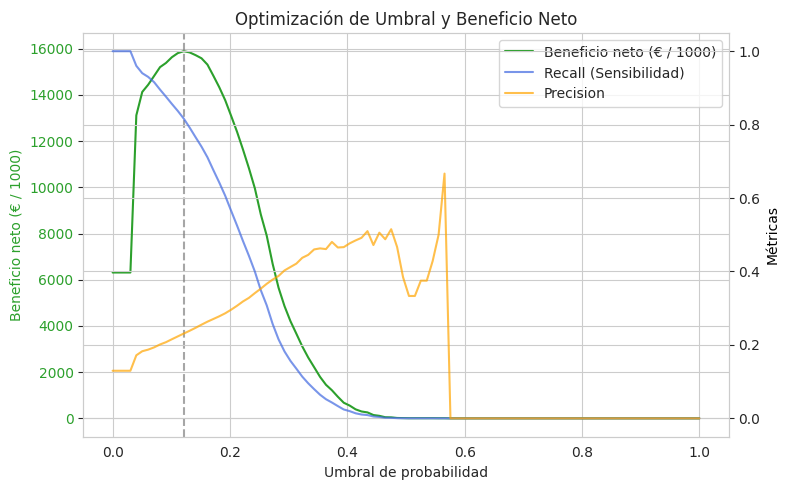


📈 RESUMEN DEL ANÁLISIS ECONÓMICO:
   • El umbral óptimo (0.12) maximiza el beneficio económico esperado.
   • Umbrales bajos → más recall (más detección) pero más coste.
   • Umbrales altos → más precisión, pero más falsos negativos.
   • Este análisis permite seleccionar el punto ideal según estrategia clínica o económica.


In [6]:
# =============================================================================
# 13. 💰 OPTIMIZACIÓN DE UMBRAL Y ANÁLISIS ECONÓMICO (versión adaptada a dataset real)
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split
import warnings, os

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

print("\n13. 💰 OPTIMIZACIÓN DE UMBRAL Y ANÁLISIS ECONÓMICO")

try:
    # ------------------------------------------------------------
    # 1️⃣ Verificar o crear datos previos
    # ------------------------------------------------------------
    if "y_test" not in locals() or "y_cal" not in locals():
        print("⚠️ No se encontraron datos previos. Generando entorno mínimo para análisis...")

        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        ruta = '/content/drive/MyDrive/Copia de Dataset_sin_tratar.csv'

        if os.path.exists(ruta):
            dataset = pd.read_csv(ruta, low_memory=False, encoding="latin-1")
            print(f"✅ Dataset cargado desde Drive: {dataset.shape[0]:,} filas × {dataset.shape[1]} columnas")
        else:
            raise FileNotFoundError("No se encontró el dataset en Drive.")

        # Verificar columna objetivo
        if "DIABETE3" not in dataset.columns:
            raise ValueError("No se encontró la columna objetivo 'DIABETE3' en el dataset.")

        # Crear variable binaria: Diabetes (1) vs No Diabetes (3,4)
        dataset["DIABETES_BINARY"] = dataset["DIABETE3"].apply(lambda x: 1 if x == 1 else 0)

        # Seleccionar variables relevantes (si existen en el dataset)
        posibles_vars = ['_AGE80', '_BMI5', '_RFHYPE5', 'BPHIGH4', 'GENHLTH', '_TOTINDA', 'SMOKE100']
        features = [v for v in posibles_vars if v in dataset.columns]

        if len(features) < 3:
            # Si faltan, tomar las primeras variables numéricas disponibles
            features = dataset.select_dtypes(include=['number']).columns.tolist()[:10]
            print("⚠️ Usando primeras variables numéricas como features.")

        X = dataset[features].fillna(dataset[features].median())
        y = dataset["DIABETES_BINARY"]

        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

        # Entrenar modelo y calibrar
        model = RandomForestClassifier(random_state=42, n_estimators=100)
        model.fit(X_train, y_train)
        calibrated = CalibratedClassifierCV(model, method="isotonic", cv=3)
        calibrated.fit(X_train, y_train)
        y_cal = calibrated.predict_proba(X_test)[:, 1]

        print(f"✅ Modelo entrenado y calibrado. Features usadas: {features}")

    else:
        print("✅ Datos de calibración detectados en memoria. Continuando...")

    # ------------------------------------------------------------
    # 2️⃣ Parámetros económicos
    # ------------------------------------------------------------
    cost_per_FP = 30     # coste estimado de prueba innecesaria
    savings_per_TP = 250 # ahorro estimado por detección temprana
    prevalence = np.mean(y_test)

    print(f"\n💵 Parámetros económicos:")
    print(f"   • Coste por FP: {cost_per_FP} €")
    print(f"   • Ahorro por TP: {savings_per_TP} €")
    print(f"   • Prevalencia estimada: {prevalence:.2%}")

    # ------------------------------------------------------------
    # 3️⃣ Calcular métricas y beneficio neto para distintos umbrales
    # ------------------------------------------------------------
    thresholds = np.linspace(0, 1, 100)
    results = []

    for thr in thresholds:
        y_pred = (y_cal >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        net_benefit = tp * savings_per_TP - fp * cost_per_FP
        net_benefit_per_1k = net_benefit / len(y_test) * 1000

        results.append({
            "threshold": thr,
            "precision": precision,
            "recall": recall,
            "specificity": specificity,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "net_benefit_per_1k": net_benefit_per_1k
        })

    results_df = pd.DataFrame(results)

    # ------------------------------------------------------------
    # 4️⃣ Umbral óptimo
    # ------------------------------------------------------------
    best_idx = results_df["net_benefit_per_1k"].idxmax()
    best_thr = results_df.loc[best_idx, "threshold"]
    best_benefit = results_df.loc[best_idx, "net_benefit_per_1k"]

    print(f"\n🏆 UMBRAL ÓPTIMO: {best_thr:.2f}")
    print(f"   • Beneficio máximo: {best_benefit:.2f} € por 1000 personas")
    print(f"   • Recall: {results_df.loc[best_idx, 'recall']:.2f}")
    print(f"   • Precision: {results_df.loc[best_idx, 'precision']:.2f}")
    print(f"   • Specificity: {results_df.loc[best_idx, 'specificity']:.2f}")

    # ------------------------------------------------------------
    # 5️⃣ Visualización del beneficio neto y métricas
    # ------------------------------------------------------------
    fig, ax1 = plt.subplots(figsize=(8,5))
    color1 = "tab:green"

    ax1.plot(results_df["threshold"], results_df["net_benefit_per_1k"], color=color1, label="Beneficio neto (€ / 1000)")
    ax1.set_xlabel("Umbral de probabilidad")
    ax1.set_ylabel("Beneficio neto (€ / 1000)", color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.axvline(best_thr, color="gray", linestyle="--", alpha=0.7)

    ax2 = ax1.twinx()
    ax2.plot(results_df["threshold"], results_df["recall"], color="royalblue", label="Recall (Sensibilidad)", alpha=0.7)
    ax2.plot(results_df["threshold"], results_df["precision"], color="orange", label="Precision", alpha=0.7)
    ax2.set_ylabel("Métricas", color="black")

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

    plt.title("Optimización de Umbral y Beneficio Neto")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # 6️⃣ Resumen
    # ------------------------------------------------------------
    print("\n📈 RESUMEN DEL ANÁLISIS ECONÓMICO:")
    print(f"   • El umbral óptimo ({best_thr:.2f}) maximiza el beneficio económico esperado.")
    print(f"   • Umbrales bajos → más recall (más detección) pero más coste.")
    print(f"   • Umbrales altos → más precisión, pero más falsos negativos.")
    print("   • Este análisis permite seleccionar el punto ideal según estrategia clínica o económica.")

except Exception as e:
    print(f"❌ Error en optimización de umbral: {e}")
